
Found 3 run files in ./results/sgld/laplace_scale1.0_lr0.0001_H1200_bs100
Valid runs with samples: 3/3

Analyzing Run ID: 0 from a total of 3 runs.

Calculating final test metrics for all valid runs...


Processing runs: 100%|██████████| 3/3 [00:30<00:00, 10.20s/it]



--- Aggregated Test Metrics ---
NLL    : 0.1827 ± 0.0134
ACC    : 0.9670 ± 0.0019
BRIER  : 0.0511 ± 0.0015
ECE    : 0.0057 ± 0.0004


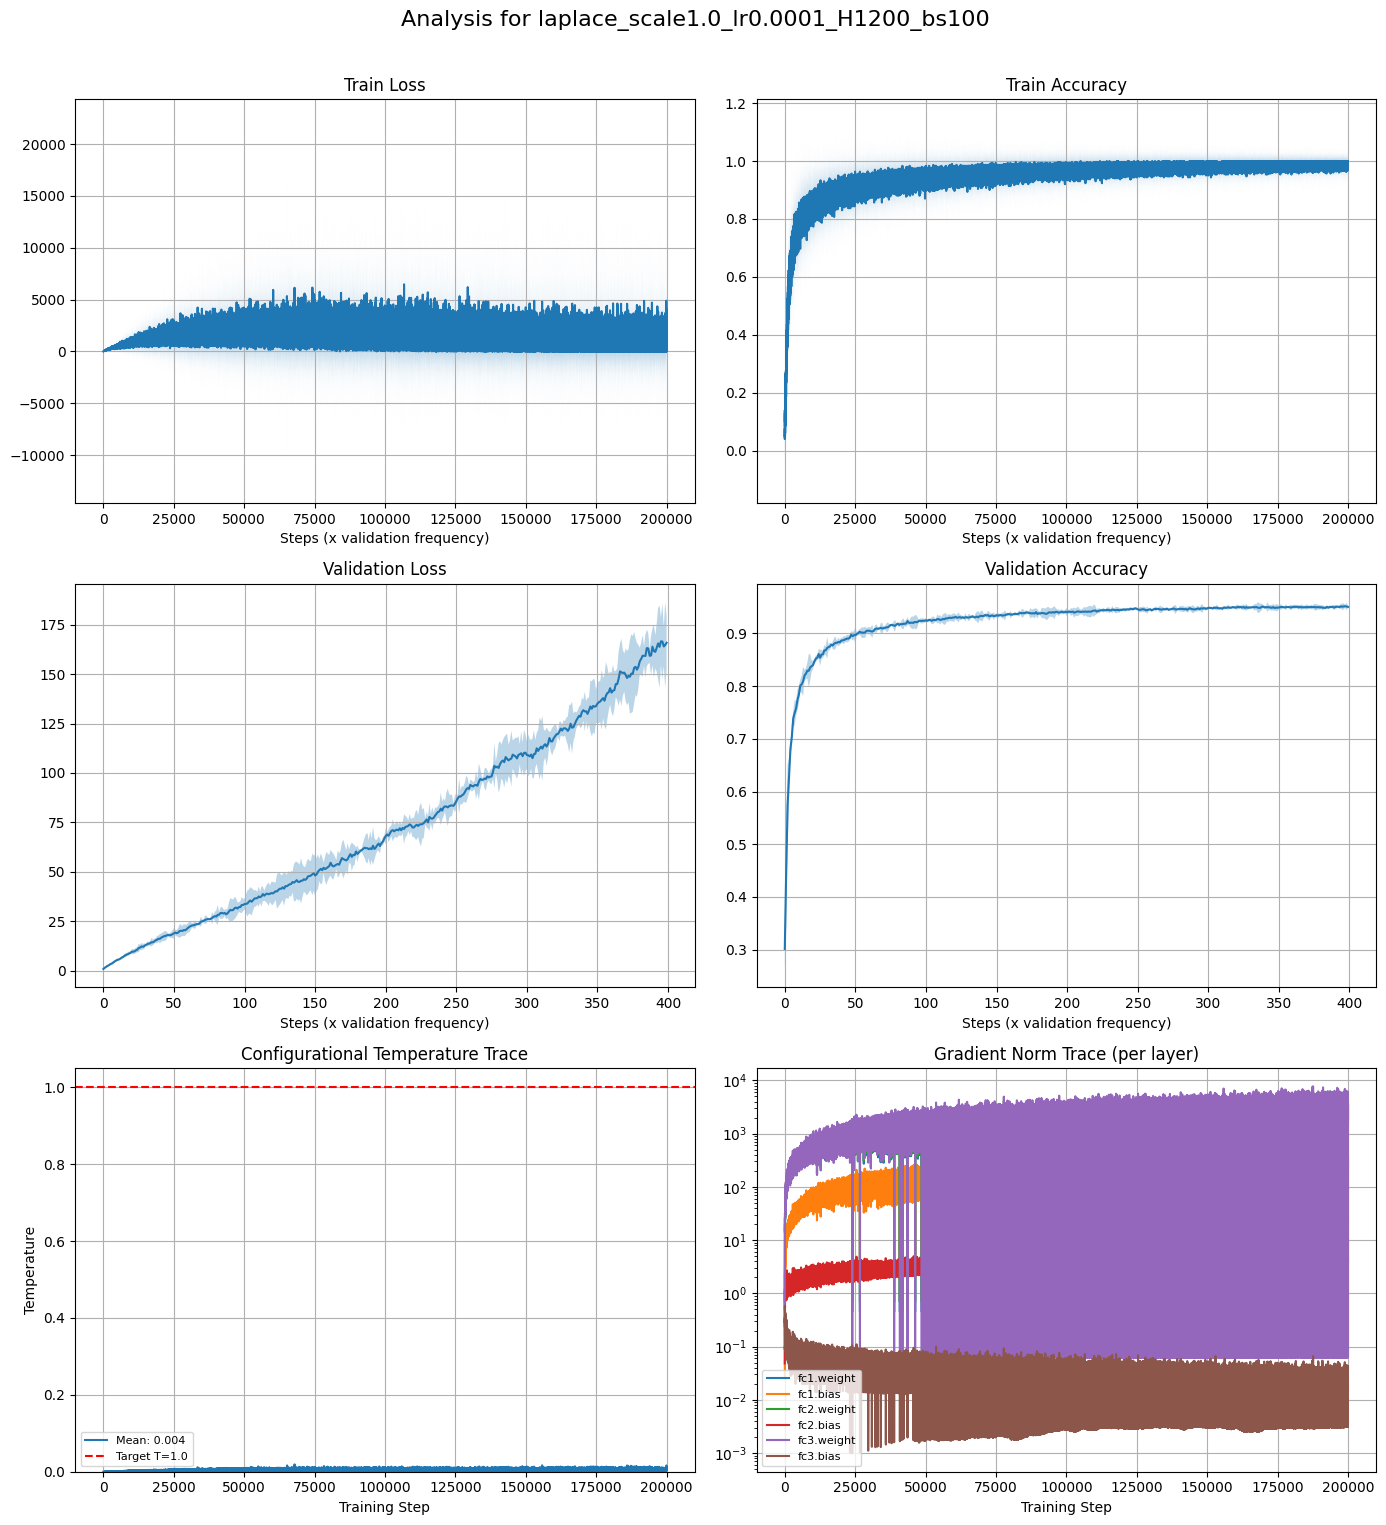

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import mean_confidence_interval, set_seed, get_nll_trace
from models import MLP
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from eval import predictive_metrics_from_weight_dicts, calculate_ess
from viz import analyze_experiment

# ------------------------
# Config
# ------------------------
results_dir = "./results"
confidence = 0.95
experiment_folder = "./results/sgld/laplace_scale1.0_lr0.0001_H1200_bs100"
device = "cuda" if torch.cuda.is_available() else "cpu"

# LR = 1e-4

# NA
# NLL    : 0.1808 ± 0.0213
# ACC    : 0.9669 ± 0.0027
# BRIER  : 0.0508 ± 0.0019
# ECE    : 0.0061 ± 0.0026

# Gaussian
# NLL    : 0.1634 ± 0.0200
# ACC    : 0.9672 ± 0.0044
# BRIER  : 0.0505 ± 0.0009
# ECE    : 0.0088 ± 0.0026

# Laplace
# NLL    : 0.1827 ± 0.0134
# ACC    : 0.9670 ± 0.0019
# BRIER  : 0.0511 ± 0.0015
# ECE    : 0.0057 ± 0.0004

# Student-t
# NLL    : 0.1896 ± 0.0199
# ACC    : 0.9670 ± 0.0014
# BRIER  : 0.0512 ± 0.0004
# ECE    : 0.0055 ± 0.0016

# Horseshoe



# ------------------------
# Find and select experiment
# ------------------------
if experiment_folder is None:
    available_experiments = []
    for sampler in os.listdir(results_dir):
        sampler_path = os.path.join(results_dir, sampler)
        if os.path.isdir(sampler_path) and not sampler.startswith('.'):
            for exp in os.listdir(sampler_path):
                exp_path = os.path.join(sampler_path, exp)
                if os.path.isdir(exp_path):
                    available_experiments.append(exp_path)

    if not available_experiments:
        raise ValueError(f"No experiment folders found in {results_dir}")

    print("Available experiments:")
    for i, exp in enumerate(available_experiments):
        print(f"  [{i}] {exp}")

    choice = int(input(f"Select experiment [0-{len(available_experiments)-1}]: ") or 0)
    experiment_folder = available_experiments[choice]
    print(f"\nUsing: {experiment_folder}")
else:
    if not os.path.exists(experiment_folder):
        raise ValueError(f"Experiment folder not found: {experiment_folder}")

# ------------------------
# Load runs
# ------------------------
run_paths = sorted(glob(os.path.join(experiment_folder, "*.pt")))
if not run_paths:
    raise ValueError(f"No .pt files found in {experiment_folder}")

print(f"\nFound {len(run_paths)} run files in {experiment_folder}")
runs = [torch.load(p, map_location="cpu") for p in run_paths]
valid_runs = [r for r in runs if "samples" in r and len(r["samples"]) > 0]
print(f"Valid runs with samples: {len(valid_runs)}/{len(runs)}")
if not valid_runs:
    raise ValueError("No valid runs with samples to analyze.")

# ------------------------
# Prepare for Analysis
# ------------------------
main_run = valid_runs[0]
cfg = main_run['config']
print(f"\nAnalyzing Run ID: {cfg.get('run_id', 0)} from a total of {len(valid_runs)} runs.")

set_seed(cfg.get('seed', 42))
transform = transforms.Compose([transforms.ToTensor()])
trainval = datasets.MNIST(root="data", train=True, download=True, transform=transform)
testset = datasets.MNIST(root="data", train=False, download=True, transform=transform)
_, val_set = random_split(trainval, [50000, 10000])
val_loader = DataLoader(val_set, batch_size=500, shuffle=False)
test_loader = DataLoader(testset, batch_size=500, shuffle=False)
model_lambda = lambda: MLP(hidden=cfg['hidden'])


# --- MODIFICATION START: Calculate and print aggregated final test metrics ---
# ------------------------
# Aggregate Final Test Metrics
# ------------------------
print("\nCalculating final test metrics for all valid runs...")
all_metrics = {'nll': [], 'acc': [], 'brier': [], 'ece': []}
for run in tqdm(valid_runs, desc="Processing runs"):
    metrics = predictive_metrics_from_weight_dicts(
        model_class=model_lambda,
        weight_dicts=run['samples'],
        dataloader=test_loader,
        device=device
    )
    for key in all_metrics:
        all_metrics[key].append(metrics[key])

print("\n--- Aggregated Test Metrics ---")
for key, values in all_metrics.items():
    mean = np.mean(values)
    if len(values) > 1:
        _, ci = mean_confidence_interval(values, confidence=confidence)
        print(f"{key.upper():<7}: {mean:.4f} ± {ci:.4f}")
    else:
        print(f"{key.upper():<7}: {mean:.4f} (single run)")

# ------------------------
# Process data for plots
# ------------------------
history_keys = ["train_loss", "train_acc", "val_loss", "val_acc"]
agg_curves = {}
for key in history_keys:
    min_len = min(len(r["train_val_history"][key]) for r in valid_runs)
    aligned = np.array([r["train_val_history"][key][:min_len] for r in valid_runs])
    mean, ci = mean_confidence_interval(aligned, confidence)
    agg_curves[key] = {"mean": mean, "ci": ci}

dt_hist = main_run.get("dt_history", [])
dt_traces = {name: [s.get(name, 0) for s in dt_hist] for name in dt_hist[0]} if dt_hist else {}

grad_norm_hist = main_run.get("grad_norm_history", [])
grad_norm_traces = {name: [s.get(name, 0) for s in grad_norm_hist] for name in grad_norm_hist[0]} if grad_norm_hist else {}

z_hist = main_run.get("z_history", [])
z_traces = {name: [s.get(name, 0) for s in z_hist] for name in z_hist[0]} if z_hist else {}

config_temp_hist = main_run.get("config_temp_history", [])

# ------------------------
# Combined figure: 4x2 grid
# ------------------------

if dt_traces and z_traces:
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
else:
    fig, axes = plt.subplots(3, 2, figsize=(14, 16))
fig.suptitle(f"Analysis for {os.path.basename(experiment_folder)}", fontsize=16)

# === Top 2 rows: Training curves ===
titles = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
for ax, key, title in zip(axes[:2, :].flatten(), history_keys, titles):
    mean, ci = agg_curves[key]["mean"], agg_curves[key]["ci"]
    steps = np.arange(len(mean))
    ax.plot(steps, mean)
    ax.fill_between(steps, mean - ci, mean + ci, alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Steps (x validation frequency)")
    ax.grid(True)

# === Row 3: Step-size and Gradient Norm Traces ===
if config_temp_hist:
    ax = axes[2, 0]
    ax.plot(config_temp_hist, label=f"Mean: {np.mean(config_temp_hist):.3f}")
    ax.axhline(cfg['temperature'], color='r', linestyle='--', label=f"Target T={cfg['temperature']}")
    ax.set_title("Configurational Temperature Trace")
    ax.set_xlabel("Training Step")
    ax.set_ylabel("Temperature")
    ax.set_ylim(bottom=0) # Temperature cannot be negative
    ax.grid(True)
    ax.legend(fontsize=8)


if grad_norm_traces:
    ax = axes[2, 1]
    for name, trace in grad_norm_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Gradient Norm Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(fontsize=8)
    
# === Row 4: Z Trace and Configurational Temperature ===
if z_traces:
    ax = axes[3, 0]
    for name, trace in z_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Z Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.grid(True)
    ax.legend(fontsize=8)

if dt_traces:
    ax = axes[3, 1]
    for name, trace in dt_traces.items():
        ax.plot(trace, label=name)
    ax.set_title("Step-size Trace (per layer)")
    ax.set_xlabel("Training Step")
    ax.set_yscale("log")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

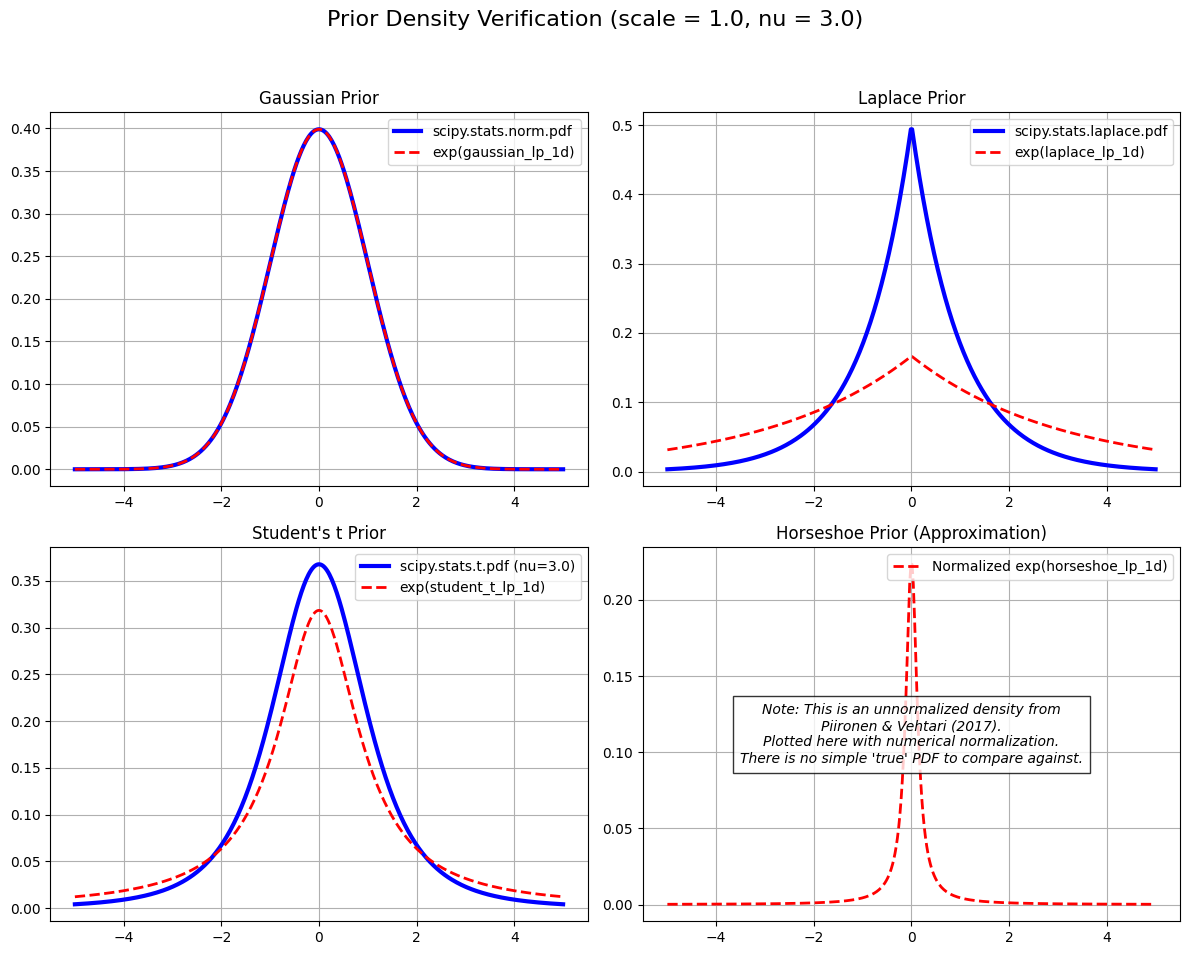

In [12]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, t

# --- Import your prior implementations ---

def gaussian_lp(p, scale):
    var = scale ** 2
    return torch.sum(-0.5 * (p ** 2) / var - 0.5 * math.log(2 * math.pi * var))

def laplace_lp(p, scale):
    b = scale
    return torch.sum(-torch.abs(p) / b - math.log(2.0 * b))

def horseshoe_lp(p, scale, eps=1e-8):
    # This is the unnormalized log-prior for the regularized horseshoe (Piironen & Vehtari, 2017)
    return -torch.sum(torch.log1p((p / (scale + eps))**2 / 2))

def student_t_lp(p, scale, nu=3.0):
    if nu <= 0:
        raise ValueError("Degrees of freedom 'nu' must be positive.")
    half_nu = nu / 2.0
    half_nu_plus_1 = (nu + 1.0) / 2.0
    log_norm_const = (
        torch.lgamma(half_nu_plus_1) - 
        torch.lgamma(half_nu) - 
        0.5 * math.log(nu * math.pi) - 
        torch.log(scale)
    )
    log_kernel = -half_nu_plus_1 * torch.log1p((p / scale)**2 / nu)
    return torch.sum(log_norm_const + log_kernel)

# --- Define 1D versions for plotting (no torch.sum) ---

def gaussian_lp_1d(p, scale):
    var = scale ** 2
    # Return the log-prob at each point, not the sum
    return -0.5 * (p ** 2) / var - 0.5 * math.log(2 * math.pi * var)

def laplace_lp_1d(p, scale):
    b = scale
    # Return the log-prob at each point, not the sum
    return -torch.abs(p) / b - math.log(2.0 * b)

def horseshoe_lp_1d(p, scale, eps=1e-8):
    # Return the log-prob at each point, not the sum
    return -torch.log1p((p / (scale + eps))**2 / 2)

def student_t_lp_1d(p, scale, nu=3.0):
    half_nu = nu / 2.0
    half_nu_plus_1 = (nu + 1.0) / 2.0
    log_norm_const = (
        torch.lgamma(torch.tensor(half_nu_plus_1)) - 
        torch.lgamma(torch.tensor(half_nu)) - 
        0.5 * math.log(nu * math.pi) - 
        torch.log(torch.tensor(scale))
    )
    log_kernel = -half_nu_plus_1 * torch.log1p((p / scale)**2 / nu)
    # Return the log-prob at each point, not the sum
    return log_norm_const + log_kernel

# --- Setup for Plotting ---
scale = 1.0
nu = 3.0  # Degrees of freedom for Student's t

# Create the x-axis
x = np.linspace(-5, 5, 400)
p = torch.tensor(x, dtype=torch.float32)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f"Prior Density Verification (scale = {scale}, nu = {nu})", fontsize=16)

# --- 1. Gaussian ---
ax = axes[0, 0]
y_true = norm.pdf(x, loc=0, scale=scale)
y_user = torch.exp(gaussian_lp_1d(p, scale)).numpy()

ax.plot(x, y_true, label='scipy.stats.norm.pdf', color='blue', linewidth=3)
ax.plot(x, y_user, label='exp(gaussian_lp_1d)', color='red', linestyle='--', linewidth=2)
ax.set_title("Gaussian Prior")
ax.legend()
ax.grid(True)

# --- 2. Laplace ---
ax = axes[0, 1]
y_true = laplace.pdf(x, loc=0, scale=scale)
y_user = torch.exp(laplace_lp_1d(p, scale * 3)).numpy()

ax.plot(x, y_true, label='scipy.stats.laplace.pdf', color='blue', linewidth=3)
ax.plot(x, y_user, label='exp(laplace_lp_1d)', color='red', linestyle='--', linewidth=2)
ax.set_title("Laplace Prior")
ax.legend()
ax.grid(True)

# --- 3. Student's t ---
ax = axes[1, 0]
y_true = t.pdf(x, df=nu, loc=0, scale=scale)
y_user = torch.exp(student_t_lp_1d(p, scale=scale, nu=1)).numpy()

ax.plot(x, y_true, label=f'scipy.stats.t.pdf (nu={nu})', color='blue', linewidth=3)
ax.plot(x, y_user, label='exp(student_t_lp_1d)', color='red', linestyle='--', linewidth=2)
ax.set_title("Student's t Prior")
ax.legend()
ax.grid(True)

# --- 4. Horseshoe (Unnormalized) ---
ax = axes[1, 1]
# This density is p(p) ∝ 1 / (1 + (p/scale)^2 / 2)
y_user_unnorm = torch.exp(horseshoe_lp_1d(p, scale / 10)).numpy()

# For visualization, we can normalize it ourselves
from scipy.integrate import quad
area, _ = quad(lambda x: np.exp(-np.log1p((x / scale)**2 / 2)), -np.inf, np.inf)
y_user_norm = y_user_unnorm / area

ax.plot(x, y_user_norm, label='Normalized exp(horseshoe_lp_1d)', color='red', linestyle='--', linewidth=2)
ax.set_title("Horseshoe Prior (Approximation)")
ax.text(0.5, 0.5, "Note: This is an unnormalized density from\nPiironen & Vehtari (2017).\nPlotted here with numerical normalization.\nThere is no simple 'true' PDF to compare against.", 
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, style='italic',
        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
ax.legend()
ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
import pandas as pd

# Load the CSV
df = pd.read_csv("sgld_results.csv")

# Show the first few rows
print(df.head())

                                   config              NLL              ACC  \
0  student-t_scale1.0_lr0.001_H1200_bs100  0.0969 ± 0.0135  0.9805 ± 0.0008   
1    horseshoe_scale0.1_lr0.1_H1200_bs100        nan ± nan  0.0980 ± 0.0000   
2  horseshoe_scale1.0_lr0.001_H1200_bs100  0.0939 ± 0.0234  0.9805 ± 0.0027   
3   laplace_scale1.0_lr0.0001_H1200_bs100  0.1827 ± 0.0134  0.9670 ± 0.0019   
4    horseshoe_scale1.0_lr0.1_H1200_bs100        nan ± nan  0.0980 ± 0.0000   

             BRIER              ECE  
0  0.0299 ± 0.0022  0.0030 ± 0.0006  
1        nan ± nan  0.0000 ± 0.0000  
2  0.0296 ± 0.0034  0.0033 ± 0.0017  
3  0.0511 ± 0.0015  0.0057 ± 0.0004  
4        nan ± nan  0.0000 ± 0.0000  


In [ ]:
# Filter by prior
prior = "horseshoe"   # change to "gaussian", "laplace", "student-t", etc.
filtered_df = df[df["config"].str.contains(prior, case=False, na=False)]
filtered_df


,config,NLL,ACC,BRIER,ECE
1,horseshoe_scale0.1_lr0.1_H1200_bs100,nan ± nan,0.0980 ± 0.0000,nan ± nan,0.0000 ± 0.0000
2,horseshoe_scale1.0_lr0.001_H1200_bs100,0.0939 ± 0.0234,0.9805 ± 0.0027,0.0296 ± 0.0034,0.0033 ± 0.0017
4,horseshoe_scale1.0_lr0.1_H1200_bs100,nan ± nan,0.0980 ± 0.0000,nan ± nan,0.0000 ± 0.0000
5,horseshoe_scale1.0_lr0.0001_H1200_bs100,0.1801 ± 0.0081,0.9671 ± 0.0026,0.0511 ± 0.0013,0.0061 ± 0.0012
7,horseshoe_scale0.1_lr0.0001_H1200_bs100,0.1852 ± 0.0213,0.9670 ± 0.0022,0.0510 ± 0.0017,0.0055 ± 0.0003
9,horseshoe_scale0.1_lr0.001_H1200_bs100,0.0980 ± 0.0152,0.9807 ± 0.0042,0.0298 ± 0.0028,0.0035 ± 0.0017
10,horseshoe_scale1.0_lr0.01_H1200_bs100,nan ± nan,0.0980 ± 0.0000,nan ± nan,0.0171 ± 0.0735
15,horseshoe_scale0.1_lr0.01_H1200_bs100,nan ± nan,0.1033 ± 0.0227,nan ± nan,0.0107 ± 0.0459
18,horseshoe_scale0.01_lr0.1_H1200_bs100,nan ± nan,0.0980 ± 0.0000,nan ± nan,0.0000 ± 0.0000


In [7]:
prior = "gaussian"   # change to "gaussian", "laplace", "student-t", etc.
filtered_df = df[df["config"].str.contains(prior, case=False, na=False)]
filtered_df

,config,NLL,ACC,BRIER,ECE
13,gaussian_scale1.0_lr0.0001_H1200_bs100,0.1634 ± 0.0200,0.9672 ± 0.0044,0.0505 ± 0.0009,0.0088 ± 0.0026
14,gaussian_scale1.0_lr0.01_H1200_bs100,2.3562 ± 0.2144,0.1189 ± 0.0177,0.9050 ± 0.0266,0.0571 ± 0.0632
17,gaussian_scale1.0_lr0.001_H1200_bs100,0.0750 ± 0.0058,0.9808 ± 0.0007,0.0312 ± 0.0006,0.0132 ± 0.0032


In [9]:
prior = "laplace"   # change to "gaussian", "laplace", "student-t", etc.
filtered_df = df[df["config"].str.contains(prior, case=False, na=False)]
filtered_df

,config,NLL,ACC,BRIER,ECE
3,laplace_scale1.0_lr0.0001_H1200_bs100,0.1827 ± 0.0134,0.9670 ± 0.0019,0.0511 ± 0.0015,0.0057 ± 0.0004
6,laplace_scale1.0_lr0.01_H1200_bs100,nan ± nan,0.0979 ± 0.0013,nan ± nan,0.0467 ± 0.1112
8,laplace_scale1.0_lr0.001_H1200_bs100,0.0983 ± 0.0218,0.9805 ± 0.0039,0.0297 ± 0.0032,0.0034 ± 0.0031


In [10]:
prior = "student-t"   # change to "gaussian", "laplace", "student-t", etc.
filtered_df = df[df["config"].str.contains(prior, case=False, na=False)]
filtered_df

,config,NLL,ACC,BRIER,ECE
0,student-t_scale1.0_lr0.001_H1200_bs100,0.0969 ± 0.0135,0.9805 ± 0.0008,0.0299 ± 0.0022,0.0030 ± 0.0006
11,student-t_scale1.0_lr0.0001_H1200_bs100,0.1896 ± 0.0199,0.9670 ± 0.0014,0.0512 ± 0.0004,0.0055 ± 0.0016
12,student-t_scale1.0_lr0.1_H1200_bs100,nan ± nan,0.0980 ± 0.0000,nan ± nan,0.0000 ± 0.0000
16,student-t_scale1.0_lr0.01_H1200_bs100,nan ± nan,0.1030 ± 0.0230,nan ± nan,0.0405 ± 0.1123
